In [16]:
import geopandas as gpd
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
from shapely import wkb
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
import numpy as np

save_dir = "plots/analysis_plots"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Load warning areas shapefile
zone_shapefile_path = "WarningAreas/WarningAreas.shp"
gdf_zones = gpd.read_file(zone_shapefile_path)
gdf_zones = gdf_zones[gdf_zones.geometry.is_valid] 
gdf_zones

,id,Sottozona,geometry
0,5,Cala5,"POLYGON ((629939.244 4411525.635, 629938.285 4..."
1,7,Cala7,"POLYGON ((636182.865 4274575.855, 636199.835 4..."
2,2,Cala2,"POLYGON ((622663.501 4332282.361, 622617.46 43..."
3,4,Cala4,"MULTIPOLYGON (((588209.1 4230865.079, 588205.1..."
4,3,Cala3,"POLYGON ((613282.231 4275683.466, 613252.157 4..."
5,6,Cala6,"POLYGON ((664382.815 4375997.552, 664390.149 4..."
6,8,Cala8,"POLYGON ((585805.641 4197281.855, 585774.897 4..."
7,1,Cala1,"MULTIPOLYGON (((567553.637 4412140.529, 567553..."


In [5]:
# Extract grid attributes
climate_file_path = "../../Calabria_dataset/InputReteGood/Climatic/2017/20170701.h5"

with h5py.File(climate_file_path, "r") as h5_file:
    attributes_table = h5_file["attributes/table"][:]

attribute_names = [attr[0].decode() for attr in attributes_table]
attribute_values = [attr[1][0] for attr in attributes_table]

attributes_dict = dict(zip(attribute_names, attribute_values))

ncols = int(attributes_dict["ncols"])
nrows = int(attributes_dict["nrows"])
xllcorner = attributes_dict["xllcorner"]
yllcorner = attributes_dict["yllcorner"]
cellsize = attributes_dict["cellsize"]

attributes_dict

{'ncols': np.float32(1490.0),
 'nrows': np.float32(2592.0),
 'xllcorner': np.float32(549915.4),
 'yllcorner': np.float32(4189379.2),
 'cellsize': np.float32(100.0),
 'NODATA_value': np.float32(nan)}

In [6]:
ncols, nrows, xllcorner, yllcorner, cellsize

(1490, 2592, np.float32(549915.4), np.float32(4189379.2), np.float32(100.0))

In [7]:
# Compute real-world coordinates for each grid cell
cell_coordinates = []

for row in range(nrows):
    for col in range(ncols):
        x_coord = xllcorner + (col * cellsize)
        y_coord = yllcorner + (row * cellsize)

        cell_coordinates.append((row, col, x_coord, y_coord))

df_cell_coordinates = pd.DataFrame(cell_coordinates, columns=["Row", "Column", "X_Coord", "Y_Coord"])

In [8]:
df_cell_coordinates

,Row,Column,X_Coord,Y_Coord
0,0,0,549915.375,4189379.25
1,0,1,550015.375,4189379.25
2,0,2,550115.375,4189379.25
3,0,3,550215.375,4189379.25
4,0,4,550315.375,4189379.25
...,...,...,...,...
3862075,2591,1485,698415.375,4448479.00
3862076,2591,1486,698515.375,4448479.00
3862077,2591,1487,698615.375,4448479.00
3862078,2591,1488,698715.375,4448479.00


In [9]:
# Convert to GeoDataFrame
df_cell_coordinates = gpd.GeoDataFrame(df_cell_coordinates, 
                                       geometry=gpd.points_from_xy(df_cell_coordinates.X_Coord, df_cell_coordinates.Y_Coord), 
                                       crs="EPSG:32633")

In [12]:
df_cell_coordinates

,Row,Column,X_Coord,Y_Coord,geometry
0,0,0,549915.375,4189379.25,POINT (549915.375 4189379.25)
1,0,1,550015.375,4189379.25,POINT (550015.375 4189379.25)
2,0,2,550115.375,4189379.25,POINT (550115.375 4189379.25)
3,0,3,550215.375,4189379.25,POINT (550215.375 4189379.25)
4,0,4,550315.375,4189379.25,POINT (550315.375 4189379.25)
...,...,...,...,...,...
3862075,2591,1485,698415.375,4448479.00,POINT (698415.375 4448479)
3862076,2591,1486,698515.375,4448479.00,POINT (698515.375 4448479)
3862077,2591,1487,698615.375,4448479.00,POINT (698615.375 4448479)
3862078,2591,1488,698715.375,4448479.00,POINT (698715.375 4448479)


In [ ]:
# Assign each grid cell to a warning zone
gdf_zones_bounds = gdf_zones.total_bounds 

df_cell_coordinates = df_cell_coordinates[
    (df_cell_coordinates["X_Coord"] >= gdf_zones_bounds[0]) &
    (df_cell_coordinates["X_Coord"] <= gdf_zones_bounds[2]) &
    (df_cell_coordinates["Y_Coord"] >= gdf_zones_bounds[1]) &
    (df_cell_coordinates["Y_Coord"] <= gdf_zones_bounds[3])
]

df_cell_zones = df_cell_coordinates.sjoin(gdf_zones, how="left", predicate="intersects")

In [9]:
df_cell_zones

,Row,Column,X_Coord,Y_Coord,geometry,index_right,id,Sottozona
110313,74,53,555215.375,4196779.0,POINT (555215.375 4196779),NaN,NaN,NaN
110314,74,54,555315.375,4196779.0,POINT (555315.375 4196779),NaN,NaN,NaN
110315,74,55,555415.375,4196779.0,POINT (555415.375 4196779),NaN,NaN,NaN
110316,74,56,555515.375,4196779.0,POINT (555515.375 4196779),NaN,NaN,NaN
110317,74,57,555615.375,4196779.0,POINT (555615.375 4196779),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3805376,2553,1406,690515.375,4444679.0,POINT (690515.375 4444679),NaN,NaN,NaN
3805377,2553,1407,690615.375,4444679.0,POINT (690615.375 4444679),NaN,NaN,NaN
3805378,2553,1408,690715.375,4444679.0,POINT (690715.375 4444679),NaN,NaN,NaN
3805379,2553,1409,690815.375,4444679.0,POINT (690815.375 4444679),NaN,NaN,NaN


In [10]:
# Clean and save the final zone mapping
df_cell_zones = df_cell_zones.rename(columns={"id": "Zone_ID"}).drop(columns=["Sottozona", "index_right"])
df_cell_zones = df_cell_zones.dropna(subset=["Zone_ID"]).reset_index(drop=True)
df_cell_zones.to_parquet("cell_zones.parquet")

In [10]:
# Load precomputed cell-zone mapping
df_cell_zones = pd.read_parquet("cell_zones.parquet")
df_cell_zones

,Row,Column,X_Coord,Y_Coord,geometry,Zone_ID
0,74,179,567815.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x0eT!A\...,8.0
1,74,180,567915.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xd6T!A\...,8.0
2,74,181,568015.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\x9eU!A\...,8.0
3,74,182,568115.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0fV!A\x00...,8.0
4,74,183,568215.375,4196779.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0.W!A\x00...,8.0
...,...,...,...,...,...,...
1507648,2550,712,621115.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0
1507649,2550,713,621215.375,4444379.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0>\xf5""A\...",5.0
1507650,2551,711,621015.375,4444479.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0\xae\xf3...,5.0
1507651,2551,712,621115.375,4444479.0,"b'\x01\x01\x00\x00\x00\x00\x00\x00\xc0v\xf4""A\...",5.0


In [7]:
# Define folder paths
output_folder = "Processed_Zones"
cell_zones_folder = os.path.join(output_folder, "cell_zones")
aggregated_zones_folder = os.path.join(output_folder, "aggregated_zones")

os.makedirs(cell_zones_folder, exist_ok=True)
os.makedirs(aggregated_zones_folder, exist_ok=True)

In [8]:
df_cell_zones["geometry"] = df_cell_zones["geometry"].apply(wkb.loads)
gdf_cell_zones = gpd.GeoDataFrame(df_cell_zones, geometry="geometry", crs="EPSG:32633")
gdf_cell_zones.to_file(os.path.join(cell_zones_folder, "cell_zones.shp"))

In [9]:
df_cell_zones["X_Group"] = (df_cell_zones["X_Coord"] // 1000) * 1000
df_cell_zones["Y_Group"] = (df_cell_zones["Y_Coord"] // 1000) * 1000

df_aggregated = df_cell_zones.groupby(["X_Group", "Y_Group", "Zone_ID"]).size().reset_index(name="Cell_Count")
gdf_aggregated = gpd.GeoDataFrame(df_aggregated, 
                                  geometry=gpd.points_from_xy(df_aggregated.X_Group, df_aggregated.Y_Group), 
                                  crs="EPSG:32633")

gdf_aggregated.to_file(os.path.join(aggregated_zones_folder, "aggregated_cell_zones.shp"))

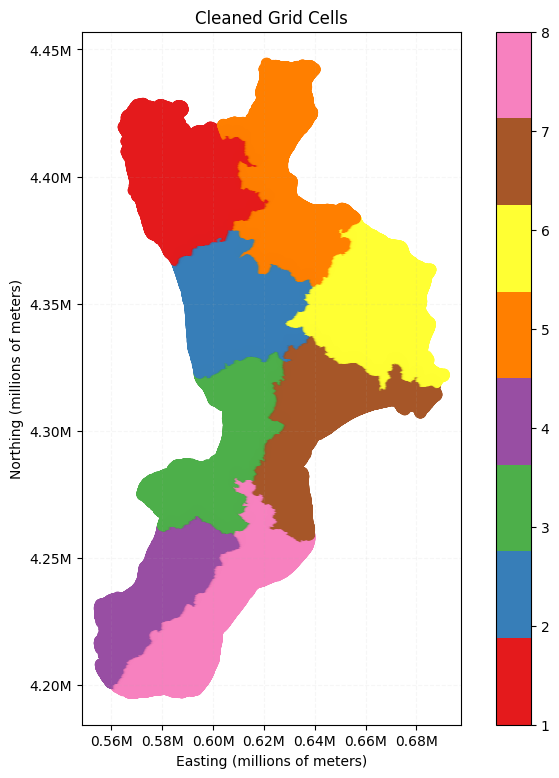

In [11]:
# Plot cleaned grid cells
cmap = ListedColormap(plt.colormaps["Set1"].colors[:8])

fig, ax = plt.subplots(figsize=(9, 9))
gdf_fire_zones = gpd.GeoDataFrame(df_cell_zones, 
                                     geometry=gpd.points_from_xy(df_cell_zones.X_Coord, 
                                                                 df_cell_zones.Y_Coord), 
                                     crs="EPSG:32633")

gdf_fire_zones.plot(column="Zone_ID", cmap=cmap, legend=True, ax=ax, markersize=50, alpha=0.7)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 1e-6:.2f}M"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y * 1e-6:.2f}M"))
plt.title("Cleaned Grid Cells")
plt.xlabel("Easting (millions of meters)")
plt.ylabel("Northing (millions of meters)")
plt.grid(True, linestyle="--", alpha=0.1)
plot_path = os.path.join(save_dir, "cleaned_grid_cells.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')


In [19]:
zone_ids = sorted(df_cell_zones["Zone_ID"].unique())
n_zones = len(zone_ids)
cmap = ListedColormap(plt.colormaps["Set1"].colors[:n_zones])
bounds = np.arange(1, n_zones + 2) 
norm = BoundaryNorm(bounds, cmap.N)

gdf_fire_zones = gpd.GeoDataFrame(
    df_cell_zones, 
    geometry=gpd.points_from_xy(df_cell_zones.X_Coord, df_cell_zones.Y_Coord),
    crs="EPSG:32633"
)


fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

gdf_fire_zones.plot(
    column="Zone_ID",
    cmap=cmap,
    norm=norm,
    legend=False,
    ax=ax,
    markersize=1  
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")


tick_positions = np.arange(1, n_zones + 1) + 0.5
tick_labels = [str(i) for i in zone_ids]

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, boundaries=bounds, ticks=tick_positions)
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label("Zone ID", labelpad=10)

plot_path = os.path.join(save_dir, "cleaned_grid_cells_final.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()
